In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)
library(BiocParallel)
setwd('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
mylox1 <- readRDS('h5ad/R/milo_full_1.5.RDS')
mylox2 <- readRDS('h5ad/R/milo_full_2.5.RDS')

In [3]:
da.res_1.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_1.5vsuntreated_full.RDS')
da.res_2.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_2.5vsuntreated_full.RDS')

In [4]:
da.res_1.5 <- annotateNhoods(mylox1, da.res_1.5, coldata_col = "fine_clustering")
da.res_1.5$fine_clustering <- ifelse(da.res_1.5$fine_clustering_fraction < 0.7, "Mixed", da.res_1.5$fine_clustering)
da.res_2.5 <- annotateNhoods(mylox2, da.res_2.5, coldata_col = "fine_clustering")
da.res_2.5$fine_clustering <- ifelse(da.res_2.5$fine_clustering_fraction < 0.7, "Mixed", da.res_2.5$fine_clustering)

In [5]:
# da.res_1.5$lognHoodSize = log(rowSums(nhoodCounts(mylox1)))
# da.res_2.5$lognHoodSize = log(rowSums(nhoodCounts(mylox2)))
# unique(da.res_1.5$Diff)

In [6]:
library(ggbeeswarm)
library(ggplot2)
new_DA_beeswarm_split <- function(da.res1, da.res2, max = 5, group.by = NULL, group_levels = NULL, split.by =NULL, alpha = 0.1, subset.nhoods = NULL, size = 2, filter = c('Mixed', 'doublets', 'Proliferating_lymphocyte')) 
{
    da.res1$split = split.by[1]
    da.res2$split = split.by[2]
    da.res <- rbind(da.res1, da.res2)
    da.res$beta[da.res$beta > max] <- max
    da.res$beta[da.res$beta < -max] <- -max
    if (!is.null(group_levels)){
        da.res[,group.by] <- factor(da.res[,group.by], levels = group_levels)
    }
    da.res <- da.res %>% filter(!get(group.by) %in% filter)
    if (!is.null(group.by)) {
        if (!group.by %in% colnames(da.res)) {
            stop(paste0(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", 
                group.by, ")?"))
        }
        if (is.numeric(da.res[, group.by])) {
            stop(paste0(group.by, " is a numeric variable. Please bin to use for grouping."))
        }
        da.res <- mutate(da.res, group_by = da.res[, group.by])
    }
    else {
        da.res <- mutate(da.res, group_by = "g1")
    }    
    if (!is.factor(da.res[, "group_by"])) {
        message(paste0("Converting group.by to factor..."))
        da.res <- mutate(da.res, factor(group_by, levels = unique(group_by)))
    }
    if (!is.null(subset.nhoods)) {
        da.res <- da.res[subset.nhoods, ]
    }
        
    da.res <- da.res %>% mutate(is_signif = ifelse(SpatialFDR < alpha, 
        1, 0)) %>% mutate(beta_color = ifelse(is_signif == 1, 
        beta, NA)) %>% arrange(group_by) %>% mutate(Nhood = factor(Nhood, 
        levels = unique(Nhood)))
    p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
        scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
#         guides(color = "none") + 
        xlab(group.by) + 
        ylab("beta") + 
        geom_quasirandom(alpha = 1, size = size) +
        coord_flip() + 
        theme_bw() + 
        theme(axis.title.y = element_blank(),
              axis.title.x = element_text(size=20, color = '#000000'),
              axis.text = element_text(size=20, color = '#000000'),
              axis.ticks = element_line(color = '#000000'),
              panel.border = element_rect(colour = "#000000")
            ) + 
        facet_wrap(split~.) +
        theme(strip.background = element_blank(), 
              strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    p$data <- p$data[order(p$data$beta_color, na.last = FALSE), ]
    return(p)
}

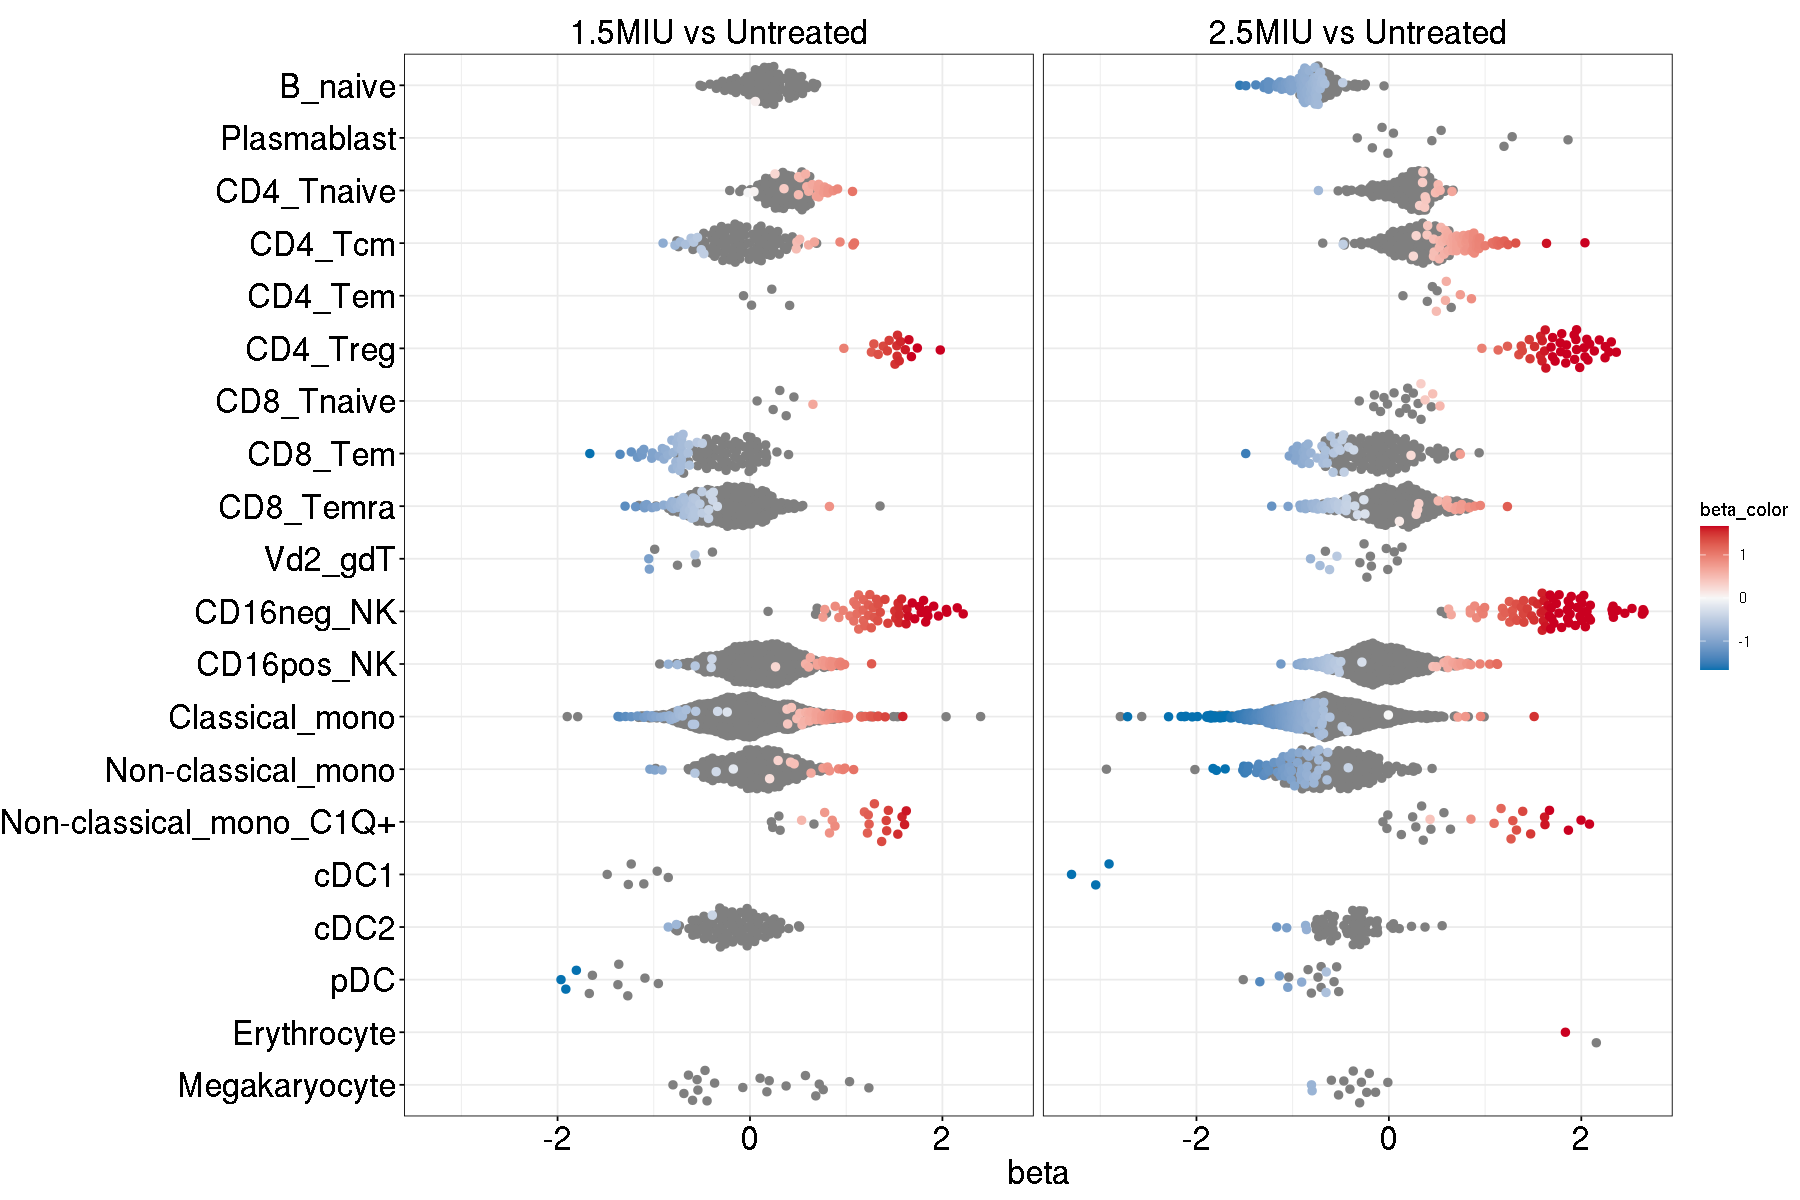

In [7]:
options(repr.plot.width=15, repr.plot.height=10)
p <- new_DA_beeswarm_split(da.res_1.5, da.res_2.5, group.by = "fine_clustering", group_levels = rev(c('B_naive', 'Plasmablast', 'CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra', 'Vd2_gdT', 'Proliferating_lymphocyte', 'CD16neg_NK', 'CD16pos_NK', 'Classical_mono', 'Non-classical_mono', 'Non-classical_mono_C1Q+', 'cDC1', 'cDC2', 'pDC', 'Erythrocyte', 'Megakaryocyte', 'doublets', 'Mixed')), split.by = c('1.5MIU vs Untreated', '2.5MIU vs Untreated'), size = 2)
p

In [8]:
ggsave('figures/milo_full.pdf', plot = p, w = 15, h = 10, useDingbats = FALSE)

In [9]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
cbind.fill <- function(...){
    nm <- list(...) 
    nm <- lapply(nm, as.matrix)
    n <- max(sapply(nm, nrow)) 
    do.call(cbind, lapply(nm, function (x) 
        rbind(x, matrix(, n-nrow(x), ncol(x))))) 
}

In [10]:
pvals = c()

In [11]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'B_naive' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'B_naive' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.05644695,-1.2546979
NA,-0.7434782
NA,-1.2870721
NA,-0.7389915
NA,-1.2981189
NA,-0.8148068
NA,-0.8796062
NA,-0.9136207
NA,-0.7274605


In [12]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Plasmablast' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Plasmablast' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,NA


In [13]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.59033194,0.5323507
0.04118967,0.3767138
0.52225419,0.3846532
0.77477100,0.3192420
0.35355630,0.4838662
0.70324140,0.3531426
0.64795713,0.5051534
0.71398779,0.5120442
0.80880028,-0.7324879


In [14]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.6122840,0.4031947
-0.7260868,0.5730673
0.4873922,0.5246364
0.9356603,0.5238002
-0.5069510,0.9458549
-0.9035318,0.8822032
-0.6699231,0.5871572
1.0700534,1.1993348
1.0861086,1.3183373


In [15]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,0.5879960
NA,0.8583571
NA,0.5969753
NA,0.4935324
NA,0.7426344


In [16]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
1.2620157,1.3867188
1.5071501,2.0691943
1.4463980,1.4670587
1.5513655,2.3118178
1.6140769,2.2468473
1.6777674,1.3753424
1.5647128,1.8380848
1.4276207,1.4594013
1.5333138,1.2328302


In [17]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.6122840,0.4031947
-0.7260868,0.5730673
0.4873922,0.5246364
0.9356603,0.5238002
-0.5069510,0.9458549
-0.9035318,0.8822032
-0.6699231,0.5871572
1.0700534,1.1993348
1.0861086,1.3183373


In [18]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,-3.047085
NA,-2.908408
NA,-3.298461


In [19]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.3915004,-0.8658223
-0.7646479,-1.1660304
-0.8496949,-0.8558910
NA,-1.0617139


In [20]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'pDC' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'pDC' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-1.964281,-1.1385286
-1.804706,-0.9063980
-1.914160,-0.6530575
NA,-0.6502184
NA,-1.0506742
NA,-1.3412400


In [21]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.59033194,0.5323507
0.04118967,0.3767138
0.52225419,0.3846532
0.77477100,0.3192420
0.35355630,0.4838662
0.70324140,0.3531426
0.64795713,0.5051534
0.71398779,0.5120442
0.80880028,-0.7324879


In [22]:
res = wilcox.test(df1[,1], mu = 0, alternative = "two.sided")
pvals <- c(pvals, res$p.value)
res


	Wilcoxon signed rank exact test

data:  df1[, 1]
V = 275, p-value = 4.768e-07
alternative hypothesis: true location is not equal to 0


In [23]:
res = wilcox.test(df2[,1], mu = 0, alternative = "two.sided")
pvals <- c(pvals, res$p.value)
res


	Wilcoxon signed rank exact test

data:  df2[, 1]
V = 66, p-value = 0.03418
alternative hypothesis: true location is not equal to 0


In [24]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.6122840,0.4031947
-0.7260868,0.5730673
0.4873922,0.5246364
0.9356603,0.5238002
-0.5069510,0.9458549
-0.9035318,0.8822032
-0.6699231,0.5871572
1.0700534,1.1993348
1.0861086,1.3183373


In [25]:
res = wilcox.test(df1[,1], mu = 0, alternative = "two.sided")
pvals <- c(pvals, res$p.value)
res


	Wilcoxon signed rank exact test

data:  df1[, 1]
V = 76, p-value = 1
alternative hypothesis: true location is not equal to 0


In [26]:
res = wilcox.test(df2[,1], mu = 0, alternative = "two.sided")
pvals <- c(pvals, res$p.value)
res


	Wilcoxon signed rank test with continuity correction

data:  df2[, 1]
V = 2203, p-value = 2.422e-12
alternative hypothesis: true location is not equal to 0


In [27]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,0.5879960
NA,0.8583571
NA,0.5969753
NA,0.4935324
NA,0.7426344


In [28]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
1.2620157,1.3867188
1.5071501,2.0691943
1.4463980,1.4670587
1.5513655,2.3118178
1.6140769,2.2468473
1.6777674,1.3753424
1.5647128,1.8380848
1.4276207,1.4594013
1.5333138,1.2328302


In [29]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD8_Tnaive' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD8_Tnaive' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.6542363,0.3330813
NA,0.3758864
NA,0.4554363
NA,0.5309500


In [30]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD8_Tem' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD8_Tem' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.7705571,-0.5269676
-0.6958867,0.2300344
-0.6284861,-0.9552202
-0.6984776,-0.8261565
-0.8531200,-0.4176118
-0.7980782,-0.9522170
-0.7641281,-0.7457998
-0.6427656,-0.4700504
-0.8779608,-0.9027983


In [31]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD8_Temra' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD8_Temra' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.4148666,-0.3547637
-0.3867647,0.3105387
-1.0959193,0.2839689
-0.8105235,-0.7573004
-0.6882329,0.8341214
-0.3811313,0.9508325
-1.0963179,-0.4442591
-0.6680522,0.6044498
-0.5207056,-0.7817045


In [32]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'MAIT' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'MAIT' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,NA


In [33]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Vd1_gdT' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Vd1_gdT' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,NA


In [34]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Vd2_gdT' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Vd2_gdT' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-1.0520689,-0.5396464
-0.5714289,-0.7157902
-1.0460751,-0.6164223
NA,-0.8142770


In [35]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD16neg_NK' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD16neg_NK' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
1.1127389,1.2842866
1.7609690,1.7677709
1.8041915,1.5930464
1.6868624,2.3189981
1.2787086,1.5818246
1.5520327,1.6683050
1.5478846,1.6122909
1.1033943,1.8542594
1.9593603,1.3753999


In [36]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD16pos_NK' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD16pos_NK' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.7545552,-0.8150277
0.7027050,-0.6068558
0.9555553,-1.1221816
0.9433145,0.7450448
0.8265398,0.7088332
0.2653568,-0.5565672
0.8335636,1.0474396
0.9380616,-0.7382651
-0.8483865,-0.7133254


In [37]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'CD16pos_SIGLEC7_NK' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'CD16pos_SIGLEC7_NK' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,NA


In [38]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Classical_mono' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Classical_mono' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.6630500,-1.464420543
0.6100781,-0.993660714
0.8116791,-1.130244582
-0.5640394,-0.005341819
-1.2348512,-1.627757759
0.8302249,-1.391079057
0.3841239,-1.241930283
0.9130295,-1.038193519
-1.0189546,-0.822424463


In [39]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Non-classical_mono' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Non-classical_mono' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.8066197,-1.2562649
0.2923682,-1.8272848
0.7586415,-1.3766818
-0.3512475,-1.7925477
0.4215901,-1.1560448
-0.1729625,-0.7794888
0.4590533,-1.0240894
-0.9884041,-0.8464267
0.8271605,-0.4224255


In [40]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'Non-classical_mono_C1Q+' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'Non-classical_mono_C1Q+' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.8833221,1.8659631
0.5365261,1.6694584
0.8265494,2.0847939
0.7763037,0.4280933
1.5365242,1.0937733
1.5803822,1.1660034
1.6067887,1.6224900
1.4208110,1.9971779
1.1894118,0.8527906


In [41]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC1' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,-3.047085
NA,-2.908408
NA,-3.298461


In [42]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'cDC2' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.3915004,-0.8658223
-0.7646479,-1.1660304
-0.8496949,-0.8558910
NA,-1.0617139


In [43]:
df1 = da.res_1.5 %>% filter(fine_clustering == 'pDC' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_2.5 %>% filter(fine_clustering == 'pdc' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-1.964281,NA
-1.804706,NA
-1.914160,NA


In [44]:
stat = c()
pvals = c()
for (x in c('B_naive', 'Plasmablast', 'CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra', 'Vd2_gdT', 'CD16neg_NK', 'CD16pos_NK', 'Classical_mono', 'Non-classical_mono', 'Non-classical_mono_C1Q+', 'cDC1', 'cDC2', 'pDC', 'Erythrocyte', 'Megakaryocyte')){
    df1 = da.res_1.5 %>% filter(fine_clustering == x & SpatialFDR <.1 ) %>% select(beta)
    df2 = da.res_2.5 %>% filter(fine_clustering == x & SpatialFDR <.1) %>% select(beta)
    df = as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]
    res = tryCatch(wilcox.test(df[,1], mu = 0, alternative = "two.sided"), error = function(e) {return(NA)})
    if (!is.na(res)){
        pvals <- c(pvals, res$p.value)
        stat <- c(stat, res$statistic)
    } else {
        pvals <- c(pvals, NA)
        stat <- c(stat, NA)
    }
    res = tryCatch(wilcox.test(df[,2], mu = 0, alternative = "two.sided"), error = function(e) {return(NA)})
    if (!is.na(res)){
        pvals <- c(pvals, res$p.value)
        stat <- c(stat, res$statistic)
    } else {
        pvals <- c(pvals, NA)
        stat <- c(stat, NA)
    }
}

Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!is.na(res)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [45]:
p.adjust(pvals, method = 'fdr')

[1] 1.000000e+00 4.334192e-14           NA           NA 1.473860e-06
 [6] 5.810547e-02 1.000000e+00 1.647124e-11           NA 1.011905e-01
[11] 1.995380e-05 9.663381e-13 1.000000e+00 1.770833e-01 2.827229e-10
[16] 3.037858e-08 1.041229e-09 3.483347e-02 2.931034e-01 1.770833e-01
[21] 1.362977e-09 4.169150e-13 1.897871e-04 3.489795e-02 1.058876e-02
[26] 9.912064e-41 2.931034e-01 2.039491e-10 1.995380e-05 1.482282e-04
[31]           NA 2.931034e-01 2.931034e-01 1.770833e-01 2.931034e-01
[36] 5.592105e-02           NA 1.000000e+00           NA 5.666667e-01

In [58]:
df = cbind(pval = pvals, padj = p.adjust(pvals, method = 'fdr'), stat)

In [59]:
row.names(df) <- c(rbind(paste0(c('B_naive', 'Plasmablast', 'CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra', 'Vd2_gdT', 'CD16neg_NK', 'CD16pos_NK', 'Classical_mono', 'Non-classical_mono', 'Non-classical_mono_C1Q+', 'cDC1', 'cDC2', 'pDC', 'Erythrocyte', 'Megakaryocyte'), '_',c('1.5MIU')),
paste0(c('B_naive', 'Plasmablast', 'CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra', 'Vd2_gdT', 'CD16neg_NK', 'CD16pos_NK', 'Classical_mono', 'Non-classical_mono', 'Non-classical_mono_C1Q+', 'cDC1', 'cDC2', 'pDC', 'Erythrocyte', 'Megakaryocyte'), '_',c('2.5MIU'))))

In [63]:
df

,pval,padj,stat
B_naive_1.5MIU,1.000000e+00,1.000000e+00,1
B_naive_2.5MIU,2.549525e-15,4.334192e-14,0
Plasmablast_1.5MIU,NA,NA,NA
Plasmablast_2.5MIU,NA,NA,NA
CD4_Tnaive_1.5MIU,4.768372e-07,1.473860e-06,275
CD4_Tnaive_2.5MIU,3.417969e-02,5.810547e-02,66
CD4_Tcm_1.5MIU,1.000000e+00,1.000000e+00,76
CD4_Tcm_2.5MIU,2.422241e-12,1.647124e-11,2203
CD4_Tem_1.5MIU,NA,NA,NA
CD4_Tem_2.5MIU,6.250000e-02,1.011905e-01,15
